In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
# Data can be found at https://archive.ics.uci.edu/ml/machine-learning-databases/00352/

frame = pd.read_excel("Online Retail.xlsx")

In [4]:
df = frame.copy()

In [5]:
# There are many NAs in the CustomerID, as they cannot be used in a cohort analysis they are dropped

df = df.dropna(subset=["CustomerID"])
df = df.drop_duplicates()

# The Quantity column has negative values, which does not make sense. The absolute value of the column is taken
df["Quantity"] = df.Quantity.apply(lambda x : abs(x))

# The UnitPrice columnn has zero values, which does not make sense. Since the description is highly heterogenous, a symbolic value of 0.05€ is applied
df["UnitPrice"].replace({0:0.05}, inplace=True)

In [6]:
# Build invoice_month and invoice_year that will be used to build cohort

df["invoice_month"] = df.InvoiceDate.apply(lambda x: x.strftime("%m"))
df["invoice_year"] = df.InvoiceDate.apply(lambda x: x.strftime("%Y"))

In [7]:
# Find the first time each customer made a purchase

df["cohort_date"] = df.groupby("CustomerID")["InvoiceDate"].transform("min")

In [8]:
# Build cohort_month and cohort_year that will be used to build the cohort variable

# Build cohort_index that will act as the index for our heatmap

df["cohort_month"] = df.cohort_date.apply(lambda x: x.strftime("%m"))
df["cohort_index"] = df.cohort_date.apply(lambda x: x.strftime("%B-%Y"))
df["cohort_index"] = pd.to_datetime(df["cohort_index"])
df["cohort_year"] = df.cohort_date.apply(lambda x: x.strftime("%Y"))

In [9]:
# All values are now string, but to carry out math operations, we need them as integers

df[["cohort_month", "cohort_year", "invoice_month", "invoice_year", "CustomerID"]] = df[["cohort_month", "cohort_year", "invoice_month", "invoice_year", "CustomerID"]].astype(np.int16)

In [10]:
# Build the cohort variable 

df.year_diff = df.invoice_year - df.cohort_year
df.month_diff = df.invoice_month - df.cohort_month
df["cohort"] = (df.year_diff * 12) + df.month_diff

C:\Users\Luca\AppData\Local\Temp\ipykernel_8588\427526064.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.year_diff = df.invoice_year - df.cohort_year
C:\Users\Luca\AppData\Local\Temp\ipykernel_8588\427526064.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.month_diff = df.invoice_month - df.cohort_month


In [11]:
# Build Pivot
retention_map = df.pivot_table(index="cohort_index", columns="cohort", values="CustomerID", aggfunc="count")

# Create percentages
retention_map = retention_map.divide(retention_map.iloc[:,0], axis=0)

# Adjust index to remove timestamps
retention_map.index = retention_map.index.strftime("%B-%Y")

<AxesSubplot:xlabel='cohort', ylabel='cohort_index'>

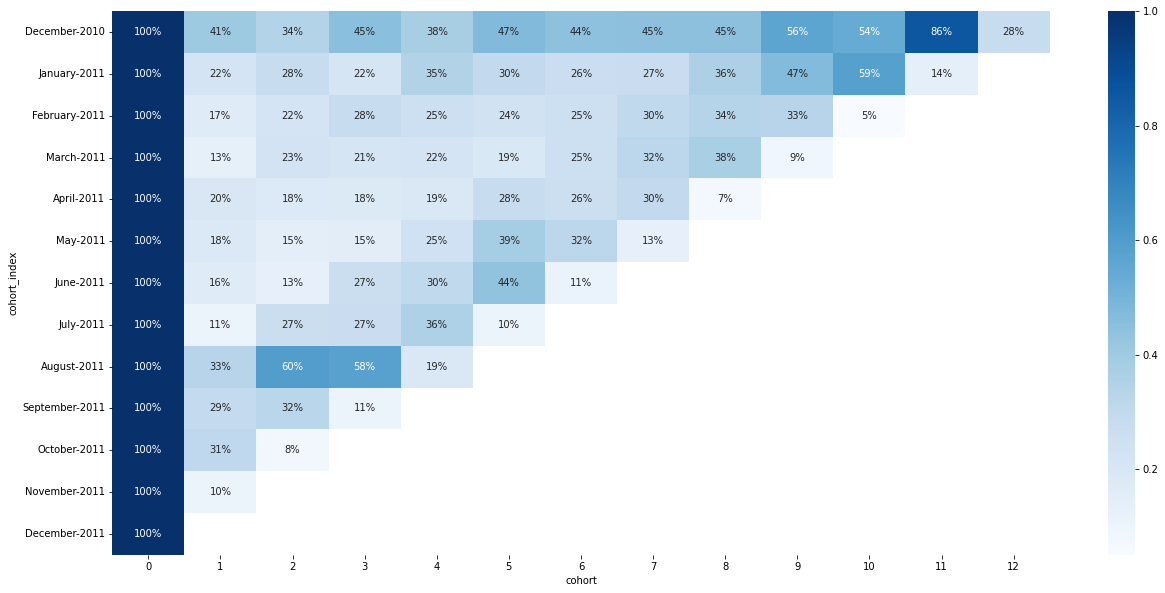

In [12]:
# Prepare Heatmap

plt.figure(figsize=(21,10))

sns.heatmap(retention_map, annot=True,cmap="Blues", fmt=".0%")

In [13]:
# Build Pivot
quantity_map = df.pivot_table(index="cohort_index", columns="cohort", values="Quantity", aggfunc=np.mean)


# Adjust index to remove timestamps
quantity_map.index = quantity_map.index.strftime("%B-%Y")

<AxesSubplot:xlabel='cohort', ylabel='cohort_index'>

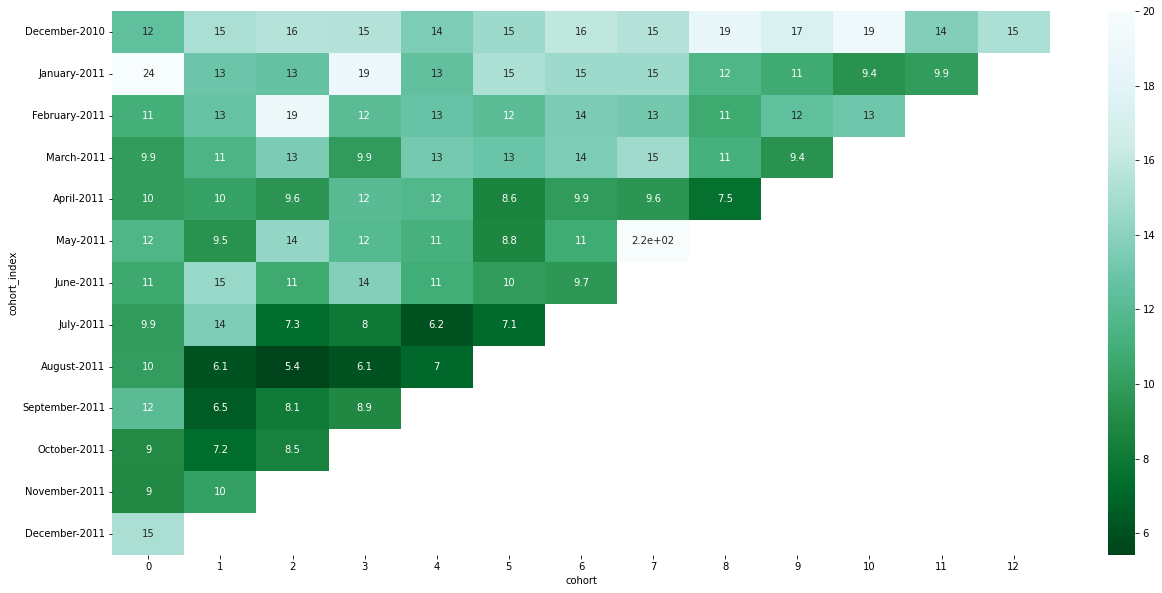

In [14]:
# Build Heatmap

plt.figure(figsize=(21,10))

sns.heatmap(quantity_map, annot=True, cmap="BuGn_r", vmax=20)

In [15]:
# Build Pivot
price_map = df.pivot_table(index="cohort_index", columns="cohort", values="UnitPrice", aggfunc=np.mean)


# Adjust index to remove timestamps
price_map.index = price_map.index.strftime("%B-%Y")

<AxesSubplot:xlabel='cohort', ylabel='cohort_index'>

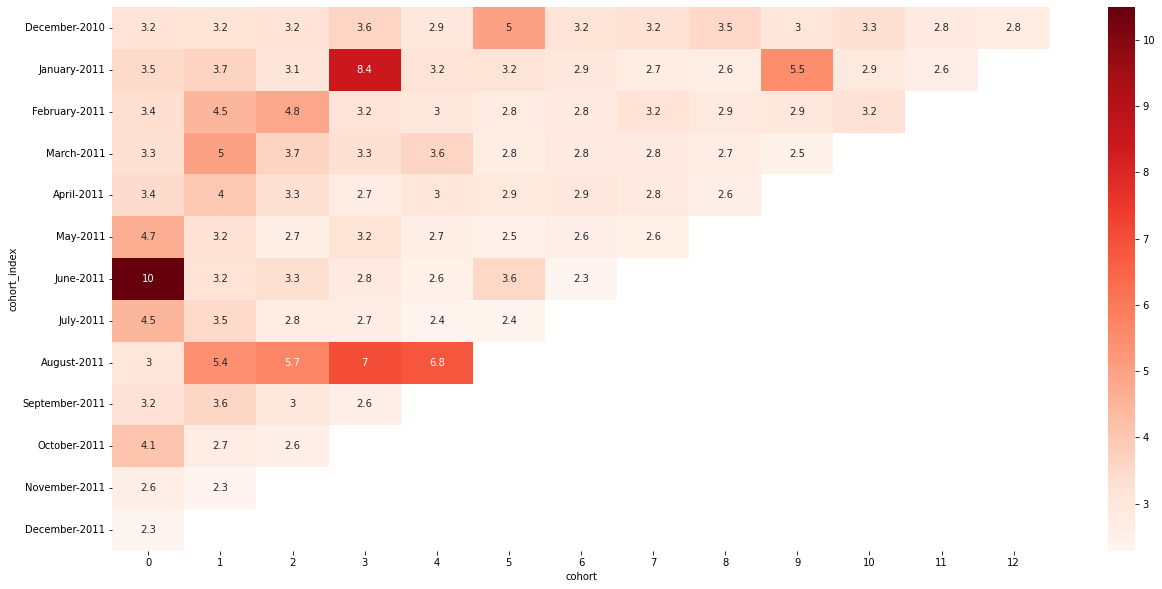

In [18]:
# Build Heatmap

plt.figure(figsize=(21,10))

sns.heatmap(price_map, annot=True, cmap="Reds")

# RFM

For intuitive and practical purposes, a business may find it useful and suitable to reduce its customers behaviour to a single dimension before preparing an ad-campaign, promotions, exclusive content or for simple analytics purposes.

The Recency, Frequency and Monetary (RFM) framework allows to divide customers based on the most important factors related to purchase: 

        - The amount they spent in total
        - How many transactions they have carried out
        - When was their latest purchase

In [19]:
# Build Monetary

df["Monetary"] = df["UnitPrice"] * df["Quantity"]
df["Monetary"] = df.groupby("CustomerID")["Monetary"].transform(np.sum)

In [20]:
# Build Frequency variable 

df["Frequency"] = df.groupby("CustomerID")["InvoiceNo"].transform("count")

In [21]:
# Define date in which one supposedly looks at data. I am assuming it is the day after the last available date

df["snapshot_date"] = df["InvoiceDate"].max() + datetime.timedelta(days=1)
df["last_order"] = df.groupby("CustomerID")["InvoiceDate"].transform("max")

# Build recency variable: difference between "today" and the last time a customer made an order

df["Recency"] = df["snapshot_date"] - df["last_order"]
df["Recency"] = df.Recency.dt.days

In [22]:
# Drop useless variables

rfm = df.drop(["InvoiceNo",
                "StockCode",
                "Description",
                "Quantity",
                "InvoiceDate",
                "UnitPrice",
                "Country",
                "invoice_month",
                "invoice_year",
                "cohort_month",
                "cohort_index",
                "cohort_year",
                "cohort",
                "cohort_date",
                "snapshot_date",
                "last_order",
                ],axis=1)

# Drop Duplicates from RFM

rfm = rfm.drop_duplicates()

In [28]:
# Building labels for customer segmentation. Recency is built backwards because higher values means the latest purchase is less recent

recency_labels = range(4,0,-1)
frequency_labels = range(1,5)
monetary_labels = range(1,5)

# The function qcut allows me to split individuals in different quartiles

recency_quartiles = pd.qcut(rfm['Recency'], q=4, labels = recency_labels)
frequency_quartiles = pd.qcut(rfm['Frequency'],q=4, labels = frequency_labels)
monetary_quartiles = pd.qcut(rfm['Monetary'],q=4,labels = monetary_labels)

# The assign function allows me to easily create multiple columns in an already existing dataframe

rfm = rfm.assign(RecencyQuartile = recency_quartiles, FrequencyQuartile = frequency_quartiles, MonetaryQuartile = monetary_quartiles)


In [37]:
# Build Customer Segment 

def buildSegment(dataset):
    return str(dataset["RecencyQuartile"]) + str(dataset["FrequencyQuartile"]) + str(dataset["MonetaryQuartile"])

rfm["CustomerSegment"] = rfm.apply(buildSegment, axis=1)

# Build score based the sum of the individual values for each category

rfm["CustomerScore"] = rfm[["RecencyQuartile", "FrequencyQuartile", "MonetaryQuartile"]].sum(axis=1)

In [49]:
# Build segment classes

def segmentClasses(dataset):
    if dataset['CustomerScore'] > 9 :
        return 'Gold'
    elif (dataset['CustomerScore'] > 5) & (dataset['CustomerScore'] <= 9 ):
        return 'Sliver'
    else:  
        return 'Bronze'

rfm["SegmentClass"] = rfm.apply(segmentClasses, axis=1)


In [51]:
rfm.SegmentClass.value_counts(normalize=True)

Sliver    0.410567
Bronze    0.296889
Gold      0.292543
Name: SegmentClass, dtype: float64

In [58]:
rfm.groupby("SegmentClass").agg({"Recency":np.mean, "Frequency":[np.mean, np.sum], "Monetary":[np.mean, np.sum]}).round(1)

Recency Frequency         Monetary           
                mean      mean     sum     mean        sum
SegmentClass                                              
Bronze         192.5      14.9   19396    268.0   347896.8
Gold            19.0     228.9  292808   5379.5  6880343.8
Sliver          71.4      49.8   89400   1263.7  2268351.9

Alternatve Segment construction based on business knowledge

In [ ]:
# Remove previous customer segmentation columns

rfm = rfm.drop(["CustomerSegment",
                "CustomerScore",
                "SegmentClass"],
                axis=1)

# Transform quartiles columns into integer type
rfm[["RecencyQuartile", "FrequencyQuartile", "MonetaryQuartile"]] = rfm[["RecencyQuartile", "FrequencyQuartile", "MonetaryQuartile"]].astype(np.int16)

In [104]:
# Quartiles standardisation: current value / Max(Value) * 100

def quartileStandardisation(x):
    return (x / 5) * 100

rfm[["RecencyQuartile", "FrequencyQuartile", "MonetaryQuartile"]] = rfm[["RecencyQuartile", "FrequencyQuartile", "MonetaryQuartile"]].apply(lambda x : quartileStandardisation(x))

In order to define the score of the customer, I'm going to set specific weights to each variable based on their assumed importance:

    - Recency -> 15%
    - Frequency -> 28%
    - Monetary -> 57%

In [105]:
rfm["CustomerScore"] = (0.15 * rfm["RecencyQuartile"]) + (0.28 * rfm["FrequencyQuartile"]) + (0.57 * rfm["MonetaryQuartile"])

In [106]:
def businessSegmentation(dataset):

    if dataset['CustomerScore'] > 75 :
        return 'Gold'
    elif (dataset['CustomerScore'] > 40) & (dataset['CustomerScore'] <= 75 ):
        return 'Sliver'
    else:  
        return 'Bronze'

rfm["SegmentClass"] = rfm.apply(businessSegmentation, axis=1)

In [107]:
# Distribution of customers

rfm.SegmentClass.value_counts(normalize=True)

Gold    1.0
Name: SegmentClass, dtype: float64

In [103]:
# Let's compute the mean and sum values of the various variables by class

rfm.groupby("SegmentClass").agg({"Recency":np.mean, "Frequency":[np.mean, np.sum], "Monetary":[np.mean, np.sum]}).round(1)

Recency Frequency         Monetary           
                mean      mean     sum     mean        sum
SegmentClass                                              
Bronze         158.4      17.9   29708    270.6   450068.3
Gold            14.1     327.9  221315   8271.6  5583331.5
Sliver          63.6      74.0  150581   1702.7  3463192.8